In [1]:
!pip install yfinance
!pip install tensorflow

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import os

In [3]:
# Define the stock ticker symbol and the date range
ticker = "AAPL"  # Example: Apple's stock
start_date = "2015-01-01"
end_date = "2024-01-01"

# Download the historical data
data = yf.download(ticker, start=start_date, end=end_date)

# Use the 'Close' price column for prediction
data = data['Close'].values
data = data.reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Scaling the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define the training data size
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create sequences for training and testing
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape the data to be suitable for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [5]:
model_path = 'lstm_stock_model.h5'

if os.path.exists(model_path):
    # Load the existing model
    model = load_model(model_path)
    print("Model loaded from disk.")
else:
    # Build a new model if it doesn't exist
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    print("New model created.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


New model created.


In [6]:
# Train or retrain the model
model.fit(X_train, y_train, batch_size=1, epochs=5)

# Save the model after training/retraining
model.save(model_path)
print("Model saved to disk.")

Epoch 1/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 69s 36ms/step - loss: 0.0051
Epoch 2/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 74s 31ms/step - loss: 5.0028e-04
Epoch 3/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 5.6079e-04
Epoch 4/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 83s 32ms/step - loss: 3.3306e-04
Epoch 5/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 54s 31ms/step - loss: 4.2859e-04


Model saved to disk.


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


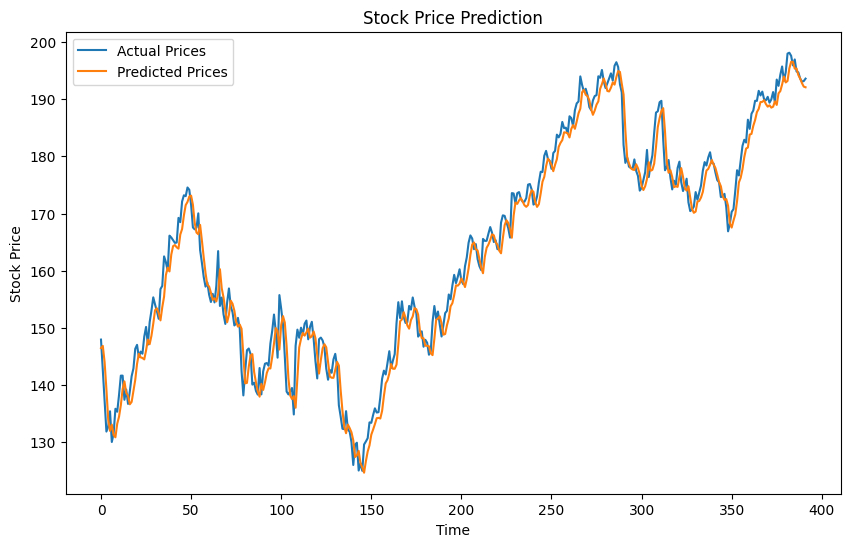

In [7]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get the actual stock prices
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(y_test_actual[0], label='Actual Prices')
plt.plot(test_predict, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [8]:
# Calculate the accuracy in probability for each entry
def calculate_accuracy(y_actual, y_pred):
    accuracy_list = []
    for actual, pred in zip(y_actual[0], y_pred):
        accuracy = 1 - abs(actual - pred[0]) / actual
        accuracy_list.append(accuracy)
    return accuracy_list

# Calculate accuracy for the test set
accuracies = calculate_accuracy(y_test_actual, test_predict)

# Print accuracy probabilities for the first few entries
for i, accuracy in enumerate(accuracies[:10]):
    print(f"Entry {i+1} - Actual Price: {y_test_actual[0][i]:.2f}, Predicted Price: {test_predict[i][0]:.2f}, Accuracy: {accuracy:.2%}")



Entry 1 - Actual Price: 147.96, Predicted Price: 146.47, Accuracy: 98.99%
Entry 2 - Actual Price: 142.64, Predicted Price: 146.86, Accuracy: 97.04%
Entry 3 - Actual Price: 137.13, Predicted Price: 144.02, Accuracy: 94.97%
Entry 4 - Actual Price: 131.88, Predicted Price: 139.27, Accuracy: 94.39%
Entry 5 - Actual Price: 132.76, Predicted Price: 133.98, Accuracy: 99.08%
Entry 6 - Actual Price: 135.43, Predicted Price: 132.00, Accuracy: 97.46%
Entry 7 - Actual Price: 130.06, Predicted Price: 133.10, Accuracy: 97.66%
Entry 8 - Actual Price: 131.56, Predicted Price: 131.25, Accuracy: 99.77%
Entry 9 - Actual Price: 135.87, Predicted Price: 130.88, Accuracy: 96.33%
Entry 10 - Actual Price: 135.35, Predicted Price: 133.25, Accuracy: 98.45%
